In [25]:
class Value: 
    
    def __init__(self, data, _children = ()): 
        
        self.data = data
        self.grad = 0
        
        self._backward = lambda: None
        self._prev = set(_children)

The most important method of this class, which handles backwards navigation along the computational graph, is the `backward` method: 

In [26]:
def backward(self, visited = None):
    if visited is None: 
        visited = set([self])
        self.grad = 1
    self._backward()           # do calculus to compute derivs of parents
    for child in self._prev:
        if not child in visited:
            visited.add(child)
            child.backward(visited)
    
Value.backward = backward

1. This case corresponds the top-level node in the computational graph. In our setting this will usually be the value of the loss function. 
2. This is the step in which we call the node's internal `_backward()` method. This method "does the calculus" and depends on how the node was computed. 
3. We then need to go through every node that is used in the computation of this node and also calculate *their* gradients. 

The `backward` method handles the recursive logic of automatic differentiation. However, it doesn't do any of the actual *math*. We need to implement this math within each of the arithmetic operations that we are going to implement for the `Value` class. Here's how we implement addition: 

In [27]:
def __add__(self, other):
    
    # make out and store its piece of the computational graph 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other))
    
    # do my calculus
    def _backward():
        self.grad  += out.grad
        other.grad += out.grad
    
    out._backward = _backward
    
    return out
    
Value.__add__ = __add__

1. This adds `other` to the computational graph, converting it to a `Value` if needed. 
2. We need to do the addition itself, log the fact that `self` and `other` were used as inputs into this operation, and return a `Value` that contains both the `data` reflecting the addition and the information about the inputs. 
3. Define a `_backward` method to update the gradients for `self` and `other`, using upstream gradient information from `out`, and attach it to `out`. This method will then be used when `backward` is called. The exact structure of `_backward` requires that we do some calculus. 

Let's do another math operation. This operation is very similar, but with a slightly more complex `_backward` method that reflects the chain rule from calculus. 

In [29]:
def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other))

    def _backward():
        self.grad  += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward

    return out

Value.__mul__ = __mul__

Having defined addition and multiplication, we can also pretty quickly define subtraction: 

In [30]:
def __neg__(self): return self * -1
def __sub__(self, other):  return self + (-other)

Value.__neg__ = __neg__
Value.__sub__ = __sub__

Let's see an example of this in action. We can define the function $f(x) = (x + 2)^2 + x^3$. Let's do this and compute $f(3)$: 

In [31]:
a = Value(3)
def f(x): return (x+2)*(x+2) + x*x*x
y = f(a)
print(f"computed value = {y.data}")

computed value = 52


Now here's the thing: because we can represent $f$ in terms of multiplications and additions, we can *also* calculate $f'(3)$, just by running the `backward` method. Since 

$$
f'(x) = 2(x+2) + 3x^2\;,
$$

we are expecting that $f'(3) = 2(3+2) + 3\cdot 3^2 = 37$. Let's check: 

In [33]:
y.backward()
print(f"derivative = {a.grad}")

derivative = 37


Looks good! 

## Autodiff Linear Regression

We've implemented enough automatic differentiation that we can differentiation any function that can be constructed out of a combination of additions, subtractions, and multiplications. This is enough to do linear regression with stochastic gradient descent! We'll focus on the 1-dimensional version, in which we want to minimize 
$$
\mathcal{L}(w, b) = \frac{1}{n}\sum_{i = 1}^n (wx_i + b - y_i)^2\;. 
$$

In stochastic gradient descent, we don't actually need to evaluate all of these terms at once: instead, we can just evaluate (and differentiate)
$$
\mathcal{L}_i(w, b) =  (wx_i + b - y_i)^2\;. 
$$

Here's the computational graph describing the loss function: 

```{mermaid}

flowchart LR
    subgraph inputs
    w
    b
    end

    w & x_i --> *
    b & * --> +
    + & y_i --> -
    - --> m[*]
    - --> m[*]
```

In order to implement this with automatic differentiation, let's first implement the predictor model $f(x) = wx + b$ as a class, using 

In [34]:
import numpy as np

class Linear:
    
    def __init__(self):
        self.w, self.b = Value(np.random.rand()), Value(np.random.rand())
    
    def __call__(self, x): return self.forward(x)

    def forward(self, x): return self.w*x + self.b

    def zero_grad(self): self.w.grad, self.b.grad = 0, 0

1. Initialize a random slope $w$ and intercept $b$. 
2. What should happen when the model accepts input. 
3. This backend to `__call__` isn't necessary; I just implemented it this way because PyTorch wants us to implement a method called `forward` for our models. 
4. Zero out the gradients (need to do after each round of gradient descent).

Now that we've implemented this model, we're already to train it. First let's create some random data: 

[Text(0.5, 0, 'Predictor'), Text(0, 0.5, 'Target')]

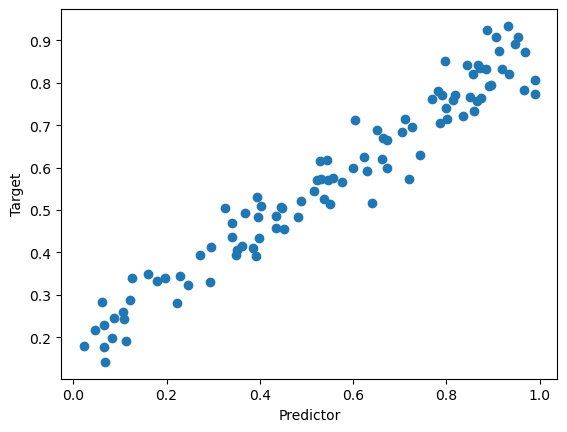

In [35]:
import numpy as np
from matplotlib import pyplot as plt

w, b = np.random.rand(), np.random.rand()

n = 100
X = np.random.rand(n)
y = w*X + b + 0.05*np.random.randn(n)

plt.scatter(X, y)
plt.gca().set(xlabel = "Predictor", ylabel = "Target")

And now let's do stochastic gradient descent: 

In [36]:
alpha = 0.01
epochs = 10

model = Linear()

order = np.arange(n) # order in which we'll visit the data

for t in range(epochs):
    np.random.shuffle(order)
    # stochastic gradient descent implementation
    for i in order: 
        model.zero_grad()
        loss = (model(X[i]) - y[i])*(model(X[i]) - y[i])
        loss.backward()
        model.w, model.b = (
            model.w - alpha*model.w.grad, 
            model.b - alpha*model.b.grad
        )
    

1. Zero out all previous gradient information in the model
2. Compute the loss on a single data pair $(x_i, y_i)$ (we're writing $z^2$ as $z \cdot z$ because we haven't yet implemented powers, only multiplication). 
3. Compute the gradients of all the model parameters using automatic differentiation. 
4. Update the model parameters using gradient descent. 

We're now able to visualize our model parameters: 

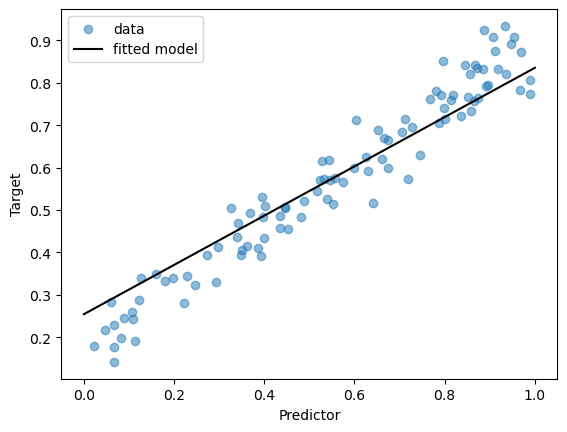

In [37]:
plt.scatter(X, y, alpha = 0.5, label = "data")
plt.gca().set(xlabel = "Predictor", ylabel = "Target", )

x_lin = np.linspace(0, 1, 101)
y_hat = model.w.data*x_lin + model.b.data

plt.plot(x_lin, y_hat, color = "black", label = "fitted model")
l = plt.legend()

Looks ok! 

## From Here to Torch

Once we understand the basic idea of automatic differentiation, it's not so hard to see what goes in to making a high-performance framework like Torch: 

1. Implement lots and lots of math operations like `__add__` and `__mul__`, with their corresponding `_backwards` methods. 
2. Do these implementations for *arrays* rather than just numbers. 
3. Do those implementations in speedy, low-level code that can run on specialized hardware. 
4. Add various utility functions to make it easy to construct more complicated mathematical functions of the inputs. 